### Imports & Configs

In [1]:
import matplotlib.pyplot as plt
import torch
import timm
import os
import cv2
import numpy as np
import mlflow
import copy

from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
from torchinfo import summary
from avalanche.evaluation.metrics.accuracy import Accuracy
from timm.scheduler.cosine_lr import CosineLRScheduler
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from src.utils import set_seeds, log_to_mlflow


/Users/pahl/workspace/braintumorclassification/ML/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
set_seeds(42)

# Dataset specifics
TRAIN_DIR = './src/data/train'
TEST_DIR = './src/data/test'

# Training specifics
NUM_WORKERS = min(4, os.cpu_count())
TRAIN_VAL_SPLIT = 0.8
BATCH_SIZE = 32
PIN_MEMORY = True

# Other
SAVE_MODEL = True

### Data Overview

In [4]:
def count_samples(directory: str):
    '''
    Count the number of samples/files in a directory.

    Args:
    -----
    directory: str
        Directory to count samples in.

    Returns:
    --------
    _ : int
        Number of samples in the directory.
    '''
    return sum(len(files) for _, _, files in os.walk(directory))


classes = os.listdir(TRAIN_DIR)
n_train = count_samples(TRAIN_DIR)
n_test = count_samples(TEST_DIR)

print(f'{len(classes)} Classes: {classes}')
print(f'{n_train} Training samples')
print(f'{n_test} Test samples')


4 Classes: ['pituitary', 'notumor', 'glioma', 'meningioma']
5712 Training samples
1311 Test samples


In [5]:
def count_samples_by_class(directory: str, classes: list):
    '''
    Count the number of samples/files in a directory for each class.

    Args:
    -----
    directory: str
        Directory to count samples in.
    classes: list
        List of class names.

    Returns:
    --------
    counts : list
        List of counts for each class.
    '''
    counts = []
    for label in classes:
        path = os.path.join(directory, label)
        count = sum(len(files) for _, _, files in os.walk(path))
        counts.append(count)
    return counts

train_counts = count_samples_by_class(TRAIN_DIR, classes)
test_counts = count_samples_by_class(TEST_DIR, classes)

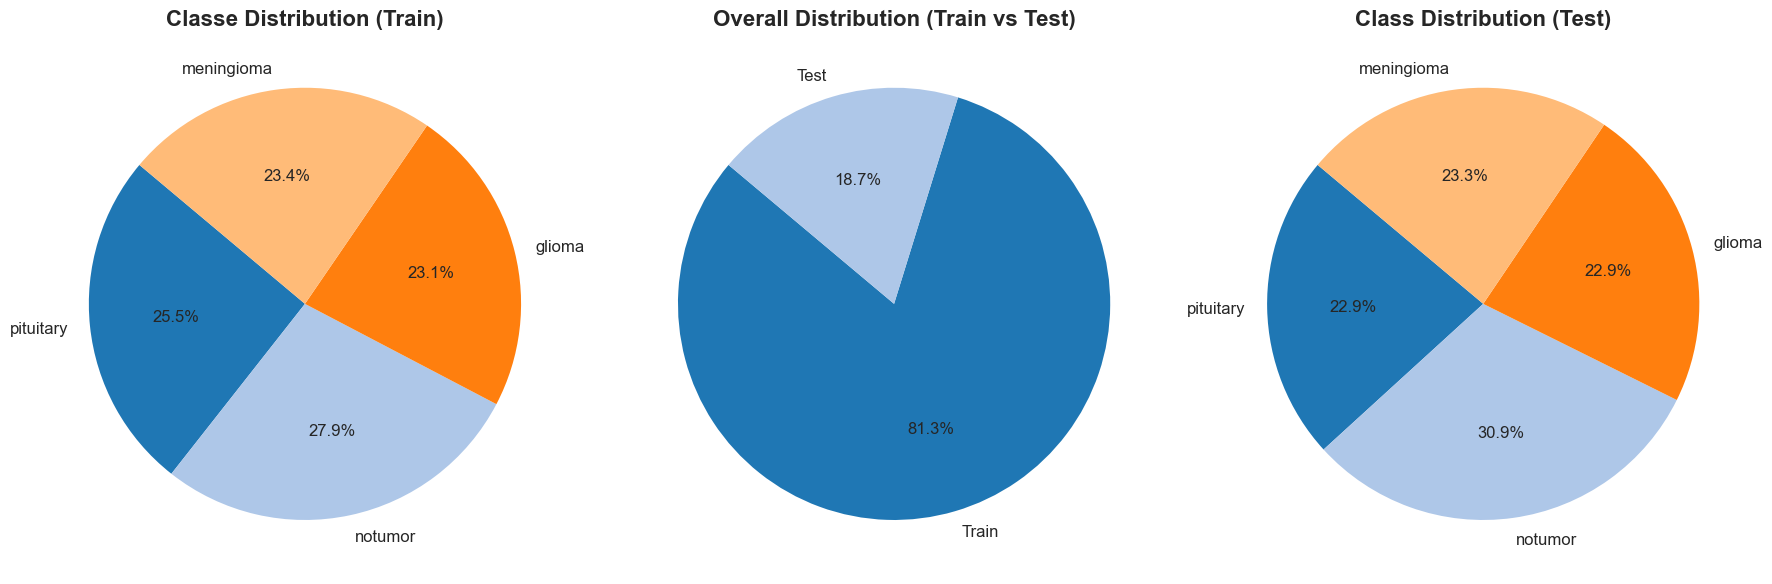

In [6]:
plt.style.use('seaborn-v0_8-darkgrid')

title_font = {'fontsize': 16, 'fontweight': 'bold'}
label_font = {'fontsize': 12}
autopct_font = {'fontsize': 10, 'fontweight': 'bold'}

fig, axs = plt.subplots(1, 3, figsize=(18, 6)) 

colors = plt.get_cmap('tab20').colors  # This gives a range of 20 colors from the 'tab20' colormap

# Training Set Distribution 
axs[0].pie(train_counts, labels=classes, autopct='%1.1f%%', startangle=140, colors=colors, textprops=label_font)
axs[0].set_title('Classe Distribution (Train)', fontdict=title_font)

# Overall Distribution 
axs[1].pie([n_train, n_test], labels=['Train', 'Test'], autopct='%1.1f%%', startangle=140, colors=colors[:2], textprops=label_font)
axs[1].set_title('Overall Distribution (Train vs Test)', fontdict=title_font)

# Testing Set Distribution
axs[2].pie(test_counts, labels=classes, autopct='%1.1f%%', startangle=140, colors=colors, textprops=label_font)
axs[2].set_title('Class Distribution (Test)', fontdict=title_font)

plt.tight_layout()  
plt.show()



### Data Augmentation & Normalization

In [7]:
# Configs for transformation
CROP_SIZE = (256, 256)
RESIZE_SIZE = (224, 224)
MEAN_IMAGENET = [0.485, 0.456, 0.406]
STD_IMAGENET = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
            transforms.CenterCrop(CROP_SIZE),
            transforms.Resize(RESIZE_SIZE, interpolation=3),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=MEAN_IMAGENET, std=STD_IMAGENET)
        ])  

test_transforms = transforms.Compose([
            transforms.CenterCrop(CROP_SIZE),
            transforms.Resize(RESIZE_SIZE, interpolation=3),
            transforms.ToTensor(),
            transforms.Normalize(mean=MEAN_IMAGENET, std=STD_IMAGENET)
        ])  

train_data = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
test_data = datasets.ImageFolder(TEST_DIR, transform=test_transforms)

CLASSES = train_data.classes
N_CLASSES = len(CLASSES)

CLASS_INDICES = train_data.class_to_idx

In [9]:
class BrainTumorData():
    '''
    A class to handle and prepare the tumor dataset for training, validation and testing.

    Attributes:
    -----------
    train_data : torch.utils.data.Dataset
        Training dataset.
    test_data : torch.utils.data.Dataset
        Testing dataset.
    train_val_split : float
        The ratio to split the training data into training and validation.
    batch_size : int
        Number of samples per batch.
    num_workers : int
        Number of subprocesses to use for data loading.
    pin_memory : bool
        Whether to copy tensors into CUDA pinned memory.

    Methods:
    --------
    _prepare_dataset():
        Split the training data into training and validation sets and prepare the data loaders.
    get_loaders():
        Return the training, validation and testing data loaders.
    '''
    
    def __init__(self, train_dataset, test_dataset, train_val_split, batch_size, num_workers, pin_memory):
        '''
        Initialize the BrainTumorData class.

        Args:
        -----
        train_dataset : torch.utils.data.Dataset
            Training dataset.
        test_dataset : torch.utils.data.Dataset
            Testing dataset.
        train_val_split : float
            The ratio to split the training data into training and validation.
        batch_size : int
            Number of samples per batch.
        num_workers : int
            Number of subprocesses to use for data loading.
        pin_memory : bool
            Whether to copy tensors into CUDA pinned memory.
        '''
        self.train_data = train_dataset
        self.test_data = test_dataset
        self.train_val_split = train_val_split
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.pin_memory = pin_memory

        self._prepare_dataset()

    def _prepare_dataset(self):
        '''
        Split the training data into training and validation sets and prepare the data loaders.
        '''

        train_size = int(self.train_val_split * len(self.train_data))
        val_size = len(self.train_data) - train_size
        self.train_data, self.val_data= random_split(self.train_data, [train_size, val_size])

        self.train_loader = DataLoader(self.train_data, shuffle=True, batch_size=self.batch_size, num_workers=self.num_workers, pin_memory=self.pin_memory)
        self.val_loader = DataLoader(self.val_data, shuffle=True, batch_size=self.batch_size, num_workers=self.num_workers, pin_memory=self.pin_memory)
        self.test_loader = DataLoader(self.test_data, shuffle=False, batch_size=self.batch_size, num_workers=self.num_workers, pin_memory=self.pin_memory)

    def get_loaders(self):
        '''
        Return the training, validation and testing data loaders.

        Returns:
        --------
        _ : tuple
            Tuple of training, validation and testing data loaders.
        '''
        
        return self.train_loader, self.val_loader, self.test_loader

In [10]:
# Data loaders for train, val and test
brain_data = BrainTumorData(train_data, test_data, TRAIN_VAL_SPLIT, BATCH_SIZE, NUM_WORKERS, PIN_MEMORY)
train_loader, val_loader, test_loader = brain_data.get_loaders()

### Model import & specification

In [11]:
pretrained_vit = timm.create_model('vit_base_patch16_224', pretrained=True, drop_path_rate=0.1)

trainable = []
for n, p in pretrained_vit.named_parameters():
    if 'head' in n:
        trainable.append(p)
    else:
        p.requires_grad = False

pretrained_vit.reset_classifier(N_CLASSES)

In [33]:
class VisionTransformerWithCustomHead(nn.Module):
    '''
    A custom Vision Transformer model with a modified MLP head for classification.

    Attributes:
    -----------
    vit_model: timm.models.vision_transformer.VisionTransformer
        Pretrained Vision Transformer model
    features: torch.nn.Sequential
        Sequential container for the feature extractor part of the model
    ln1: torch.nn.Linear
        First linear layer in the custom head
    relu: torch.nn.ReLU
        ReLU activation function
    ln2: torch.nn.Linear
        Second linear layer in the custom head

    Methods:
    --------
    forward(x: torch.Tensor):
        Forward pass of the model
    '''

    def __init__(self, model_name, num_classes):
        '''
        Initialize the VisionTransformerWithCustomHead model with a pretrained Vision Transformer model and a custom head.

        Args:
        -----
        model_name: str
            Name of the pretrained Vision Transformer model
        num_classes: int
            Number of classes for classification
        '''
        super(VisionTransformerWithCustomHead, self).__init__()

        # Loading the VIT model
        self.vit_model = timm.create_model(model_name, pretrained=True, drop_path_rate=0.1)

        for param in self.vit_model.parameters():
            param.requires_grad = False

        self.features = nn.Sequential(*list(self.vit_model.children())[:-1])

        self.ln1 = nn.Linear(768, 256)
        self.relu = nn.ReLU(inplace=True)
        self.ln2 = nn.Linear(256, num_classes)

    def forward(self, x):
        '''
        Forward pass of the model

        Args:
        -----
        x: torch.Tensor
            Input tensor to the model of shape (batch_size, channels, height, width)

        Returns:
        --------
        output: torch.Tensor
            Output tensor from the model (batch_size, num_classes)
        '''
        x = self.features(x)

        x = x.mean(dim=1)

        x = self.ln1(x)
        x = self.relu(x)
        output = self.ln2(x)
        
        return output

In [34]:
MODEL_NAME = 'vit_base_patch16_224'
custom_vit = VisionTransformerWithCustomHead(MODEL_NAME, N_CLASSES)

In [35]:
summary(model=custom_vit, 
        input_size=(32, 3, 224, 224), 
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        )

Layer (type:depth-idx)                        Input Shape          Output Shape         Param #              Trainable
VisionTransformerWithCustomHead               [32, 3, 224, 224]    [32, 4]              921,064              Partial
├─Sequential: 1-1                             [32, 3, 224, 224]    [32, 196, 768]       --                   False
│    └─PatchEmbed: 2-1                        [32, 3, 224, 224]    [32, 196, 768]       --                   False
│    │    └─Conv2d: 3-1                       [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
│    │    └─Identity: 3-2                     [32, 196, 768]       [32, 196, 768]       --                   --
│    └─Dropout: 2-2                           [32, 196, 768]       [32, 196, 768]       --                   --
│    └─Identity: 2-3                          [32, 196, 768]       [32, 196, 768]       --                   --
│    └─Identity: 2-4                          [32, 196, 768]       [32, 196, 768]  

In [16]:
summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224), 
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        )

Layer (type:depth-idx)                   Input Shape          Output Shape         Param #              Trainable
VisionTransformer                        [32, 3, 224, 224]    [32, 4]              152,064              Partial
├─PatchEmbed: 1-1                        [32, 3, 224, 224]    [32, 196, 768]       --                   False
│    └─Conv2d: 2-1                       [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
│    └─Identity: 2-2                     [32, 196, 768]       [32, 196, 768]       --                   --
├─Dropout: 1-2                           [32, 197, 768]       [32, 197, 768]       --                   --
├─Identity: 1-3                          [32, 197, 768]       [32, 197, 768]       --                   --
├─Identity: 1-4                          [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential: 1-5                        [32, 197, 768]       [32, 197, 768]       --                   False
│    └─Block: 2-

### Model & Training

In [12]:
def train(model, train_loader, val_loader, opt, scheduler, lr, batch_size, epoch=10):
    '''
    Trains and evaluates the model on the train and validation set with specified optimizer and scheduler. For
    each epoch, the model accuracy and loss is logged to MLFlow together with the learning rate and batch size.

    Args:
    -----
    model: nn.Module
        The model to be trained
    train_loader: DataLoader
        The DataLoader containing the training data
    val_loader: DataLoader
        The DataLoader containing the validation data
    opt: torch.optim.Optimizer
        The optimizer to be used for training
    scheduler: torch.optim.lr_scheduler
        The learning rate scheduler to be used
    lr: float
        The learning rate
    batch_size: int
        The batch size  
    '''

    for ep in tqdm(range(epoch)):
        model.train()
        train_acc = Accuracy()
        total_loss = 0
        for feature, label in train_loader:
            feature, label = feature.to(device), label.to(device)
            out = model(feature)
            loss = F.cross_entropy(out, label)
            opt.zero_grad()
            loss.backward()
            opt.step()

            train_acc.update(out.argmax(dim=1).view(-1), label)
            total_loss += loss.item()

        scheduler.step(ep)

        train_acc = train_acc.result()
        train_loss = total_loss / len(train_loader)
        val_acc, val_loss = test(model, val_loader)

        log_to_mlflow(model, train_acc, train_loss, val_acc, val_loss, ep, lr, batch_size)
        
        print(train_acc, train_loss, val_acc, val_loss)

    return train_acc, val_acc


@torch.no_grad()
def test(model, loader):
    '''
    Validates the model on the given data loader and returns the accuracy and average loss.

    Args:
    -----
    model: nn.Module
        The model to be evaluated
    loader: DataLoader
        The DataLoader containing the validation data

    Returns:
    --------
    acc: float
        The validation accuracy of the model
    avg_loss: float
        The average validation loss of the model
    '''
    model.eval()
    acc = Accuracy()
    total_loss = 0

    for feature, label in loader:  
        feature, label = feature.to(device), label.to(device)
        out = model(feature)
        acc.update(out.argmax(dim=1).view(-1), label)
        loss = F.cross_entropy(out, label)
        total_loss += loss.item()

    avg_loss = total_loss / len(loader)

    return acc.result(), avg_loss

In [ ]:
# Hyperparameters to use for training
params = {
    'learning_rate': np.logspace(-4, -1, 3)
    # Further hyperparameters can be inserted here
}


for lr in params['learning_rate']:
    with mlflow.start_run():
        model = copy.deepcopy(pretrained_vit)
        model.to(device)

        optimizer = torch.optim.Adam(params=model.parameters(),
                                 lr=lr, weight_decay=0.001)
        
        scheduler = CosineLRScheduler(optimizer, t_initial=100,
                                  warmup_t=10, lr_min=1e-5, warmup_lr_init=1e-6)

        train_acc, train_loss = train(model, train_loader, val_loader, optimizer, scheduler, lr, BATCH_SIZE)



### Testing & Evaluation

In [ ]:
# Konfusionsmatrix und metriekn
model_name = "brain-tumor-model-0-0.0001"
model_version = 1

best_model = mlflow.pytorch.load_model(model_uri=f'models:/{model_name}/{model_version}')

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in CLASSES}
total_pred = {classname: 0 for classname in CLASSES}

all_labels = []
all_predictions = []

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = best_model(images)
        _, predictions = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

conf_matrix = confusion_matrix(all_labels, all_predictions)

# Print out the classification report for each class
target_names = list(CLASSES)
classification_report_str = classification_report(all_labels, all_predictions, target_names=target_names)

# Output the results
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_report_str)

### Visualizations

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load or create an image (for demonstration, create a synthetic grayscale image)
img = cv2.imread('./src/data/test/glioma/Te-gl_0010.jpg')
img = cv2.resize(img, (224,224))
print(img.shape)

# Parameters
tiles_per_dim = 16  # Number of tiles per dimension
img_height, img_width, _ = img.shape
tile_height = img_height // tiles_per_dim
tile_width = img_width // tiles_per_dim

fig, ax = plt.subplots()
ax.imshow(img, cmap='gray')  # Display the image in grayscale

# Add white grid lines
for i in range(1, tiles_per_dim):
    ax.axhline(y=i * tile_height, color='white', linewidth=1)
    ax.axvline(x=i * tile_width, color='white', linewidth=1)

ax.set_axis_off()  # Hide the axes
plt.show()


In [ ]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Convert images to numpy arrays and denormalize
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
images = (images.numpy().transpose((0, 2, 3, 1)) * std + mean).clip(0, 1)

# Create a grid of images
num_images = len(images)
rows = int(np.ceil(num_images / 4))
fig, axes = plt.subplots(rows, 4, figsize=(15, 15))

# Plot images with labels
for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(images[i])
        #ax.set_title(f'Label: {labels}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
#t-SNE for all labels

In [ ]:
# Attention maps

import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

def get_attention_map(model, image_path):
    # Load and preprocess image
    img = Image.open(image_path).convert("RGB")
    config = resolve_data_config({}, model=model)
    transform = create_transform(**config)
    tensor = transform(img).unsqueeze(0)  # Add batch dimension

    # Disable gradients for lower memory usage and faster computation
    with torch.no_grad():
        # Forward pass through the model
        outputs = model(tensor)

        # Assuming the model has an 'attention_map' method that extracts the last layer's attention (many timm models support this)
        attention_map = model.blocks[-1].attn.get_attention_map()

    return attention_map.squeeze(0)  # Remove batch dim if present

# Load model
#model = timm.create_model('vit_base_patch16_224', pretrained=True)
best_model.eval()  # Set model to eval mode

# Visualize
attention_map = get_attention_map(best_model, './src/data/test/glioma/Te-gl_0010.jpg')
plt.imshow(attention_map.numpy(), cmap='hot', interpolation='nearest')
plt.show()
